In [1]:
import sys
sys.path.insert(0,'..')
from paths import *
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import joblib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import multiprocessing as mp

from IPython.display import clear_output

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA



In [2]:
analytes_selected = pd.read_csv('../../wetlab/data/patient_selection/untargeted_significant_compounds_model_results_with_site_variable_using_feces_sample_after_manual_selection.csv')
analytes_selected = analytes_selected[analytes_selected.selection_flag==True]



In [3]:
armss_data_lower = pd.read_csv('../../wetlab/data/patient_selection/patients_with_armss_data_lower.csv')
armss_data_higher = pd.read_csv('../../wetlab/data/patient_selection/patients_with_armss_data_higher.csv')
diet_info = pd.read_csv('../../wetlab/data/patient_selection/iMSMS Diet Restrictions.csv')

armss_data_lower.loc[:,'armms_category'] = 0
armss_data_higher.loc[:,'armms_category'] = 1

armss_data_combined = pd.concat([armss_data_lower, armss_data_higher], ignore_index=True)
armss_data_combined = armss_data_combined[['Record.ID', 'gARMSS', 'armms_category']]

armss_data_combined.head()

,Record.ID,gARMSS,armms_category
0,71501-0026,0.05,0
1,76401-0008,0.08,0
2,71701-0169,0.12,0
3,71801-0047,0.17,0
4,71801-0150,0.17,0


In [4]:
sample = "feces"



In [5]:
patient_ids = armss_data_combined['Record.ID'].unique()


In [6]:
if sample == "serum":
    filename = GLOBAL_SERUM_DATA_FILENAME
else:
    filename = GLOBAL_STOOL_DATA_FILENAME
    

file_path = os.path.join(DATA_ROOT_PATH, filename)

sheet_name = ["Chemical Annotation", "Sample Meta Data", "Log Transformed Data"]

analyte_metadata = pd.read_excel(file_path, engine='openpyxl', sheet_name=sheet_name[0])
patient_metadata = pd.read_excel(file_path, engine='openpyxl', sheet_name=sheet_name[1])
data = pd.read_excel(file_path, engine='openpyxl', sheet_name=sheet_name[2])

patient_metadata.loc[:, "site_code"] = patient_metadata["CLIENT_SAMPLE_ID"].apply(lambda x:x[0:3])

global_metabolomics_compound_spoke_map = pd.read_csv(os.path.join(os.path.dirname(OUTPUT_PATH), "global_metabolomics_compound_spoke_map.csv"))

analyte_columns = list(data.columns)
analyte_columns.remove("PARENT_SAMPLE_NAME")

analyte_columns_selected = global_metabolomics_compound_spoke_map[global_metabolomics_compound_spoke_map.CHEM_ID.isin(analyte_columns)]["CHEM_ID"].unique()

data_with_analyte_columns_selected = data[["PARENT_SAMPLE_NAME"]+list(analyte_columns_selected)]
selected_metadata_columns = ["PARENT_SAMPLE_NAME", "CLIENT_IDENTIFIER", "GROUP_NAME", "AGE", "BMI", "GENDER", "CLIENT_SAMPLE_ID", "CLIENT_MATRIX", "TREATMENT", "SAMPLE_AMOUNT_UNITS"]
patient_metadata_selected_columns = patient_metadata[selected_metadata_columns]
patient_metadata_selected_columns.loc[:, 'house'] = (patient_metadata_selected_columns['CLIENT_SAMPLE_ID'].str[:3] + patient_metadata_selected_columns['CLIENT_SAMPLE_ID'].str[-4:])
patient_metadata_selected_columns.loc[:, 'site'] = patient_metadata_selected_columns.loc[:, 'CLIENT_SAMPLE_ID'].str[:3]

le = LabelEncoder()
patient_metadata_selected_columns.loc[:, 'Gender_label'] = le.fit_transform(patient_metadata_selected_columns['GENDER'])

data_with_patient_metadata = pd.merge(data_with_analyte_columns_selected, patient_metadata_selected_columns, on="PARENT_SAMPLE_NAME")

selected_metadata_columns.append('Gender_label')

clear_output()

data_with_patient_metadata = data_with_patient_metadata[data_with_patient_metadata.CLIENT_SAMPLE_ID.isin(patient_ids)]



In [7]:
untargeted_analytes_selected = analytes_selected[(analytes_selected.selection_flag==True) & (analytes_selected.analyte_type == 'untargeted')]

selected_untargeted_analytes_column_ids = list(analyte_metadata[analyte_metadata.CHEMICAL_NAME.isin(untargeted_analytes_selected.analyte_name)].CHEM_ID.values)




In [8]:
patient_data_untargeted = data_with_patient_metadata[data_with_patient_metadata['CLIENT_SAMPLE_ID'].isin(patient_ids)]
patient_feature_untargeted_df = patient_data_untargeted[selected_untargeted_analytes_column_ids+['CLIENT_SAMPLE_ID']]



In [9]:


patient_feature_df = pd.merge(patient_feature_untargeted_df, armss_data_combined, left_on='CLIENT_SAMPLE_ID', right_on='Record.ID').drop('Record.ID', axis=1)

patient_feature_df.head()


,35,50,171,194,231,234,252,278,330,340,...,100010901,100015666,100016038,100019981,100020272,100020407,100022120,CLIENT_SAMPLE_ID,gARMSS,armms_category
0,-0.226544,-1.122074,-0.458623,-0.589312,-1.266715,0.325403,-0.499603,-2.033250,-1.093803,-0.172088,...,-0.582775,-2.835794,-5.422900,0.029613,-2.538195,-2.071525,-0.620576,71701-0229,7.69,1
1,0.178154,-0.592624,-0.045935,-0.001301,0.918200,0.438842,0.013201,-2.033250,0.067856,0.030257,...,0.170510,-0.196264,-0.405526,0.232838,-2.538195,0.327060,-0.075810,71501-0024,0.88,0
2,-0.558773,-1.058159,-0.120095,-1.032197,-0.866876,-0.955718,-1.150961,-2.033250,0.119276,-1.236118,...,-0.692182,-0.360571,0.432394,0.163655,-2.538195,0.297747,-1.241581,71701-0010,6.72,1
3,-0.458945,-1.936099,-0.289255,0.159331,-0.521679,-0.583276,-1.547988,-0.393023,-1.718424,-0.127831,...,-1.216436,-2.144385,-0.810815,-0.345447,-2.538195,-0.710067,-0.426056,71401-0122,8.85,1
4,0.002786,-0.721220,-2.490642,-1.930266,-0.475679,-1.364179,-0.399321,-2.033250,-0.834000,-1.662274,...,-1.031848,-1.873547,-1.106696,-1.300179,-2.538195,-1.418718,-1.253022,71701-0247,6.97,1


In [10]:

patient_feature_array = patient_feature_df.drop(['CLIENT_SAMPLE_ID', 'gARMSS', 'armms_category'], axis=1).to_numpy()


In [11]:
mean = np.mean(patient_feature_array, axis=0)
std_dev = np.std(patient_feature_array, axis=0)


patient_feature_array_normalized = (patient_feature_array - mean) / std_dev



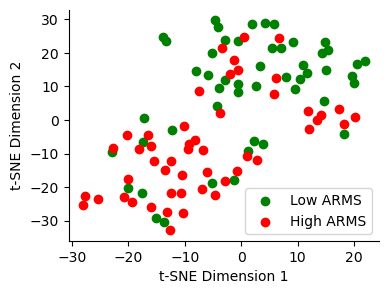

In [12]:
from sklearn.manifold import TSNE

# Assuming standardized_matrix contains your z-score standardized matrix
# Assuming patient_feature_df contains your dataframe

# Extract 'armms_category' column
armms_category = patient_feature_df['armms_category']

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=8, random_state=4355)
tsne_results = tsne.fit_transform(patient_feature_array)

# Plot t-SNE embedding with colors based on 'armms_category'
fig = plt.figure(figsize=(4,3))
plt.scatter(tsne_results[armms_category == 0, 0], tsne_results[armms_category == 0, 1], color='green', alpha=1, label='Low ARMS')
plt.scatter(tsne_results[armms_category == 1, 0], tsne_results[armms_category == 1, 1], color='red', alpha=1, label='High ARMS')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
# plt.title('t-SNE Plot of Z-score Normalized Matrix')
plt.legend(title='armms_category')
plt.legend(title='')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.grid(True)
plt.show()


# fig.savefig('../../wetlab/data/patient_selection/site_included_selected_analytes_based_patient_profile_tsne.svg', format='svg', bbox_inches='tight')
# fig.savefig('../../wetlab/data/patient_selection/site_included_selected_analytes_based_patient_profile_tsne.png', format='png', bbox_inches='tight')


In [13]:
tsne_df = patient_feature_df.copy()
tsne_df.loc[:,'tsne1'] = tsne_results[:,0]
tsne_df.loc[:,'tsne2'] = tsne_results[:,1]
tsne_df.loc[tsne_df.armms_category==0, 'armms_category']='Lower ARMSS'
tsne_df.loc[tsne_df.armms_category==1, 'armms_category']='Higher ARMSS'
tsne_df = tsne_df[['CLIENT_SAMPLE_ID','gARMSS','armms_category','tsne1','tsne2']]
tsne_df.head()

# tsne_df = tsne_df[tsne_df.CLIENT_SAMPLE_ID.str.startswith('714')]
# tsne_df.columns


# tsne_df.to_csv('../../wetlab/data/patient_selection/patient_profile_site_included.csv', index=False)


,CLIENT_SAMPLE_ID,gARMSS,armms_category,tsne1,tsne2
0,71701-0229,7.69,Higher ARMSS,-16.044497,-7.906669
1,71501-0024,0.88,Lower ARMSS,11.625902,14.085816
2,71701-0010,6.72,Higher ARMSS,-12.523287,-12.354211
3,71401-0122,8.85,Higher ARMSS,-25.356457,-23.438580
4,71701-0247,6.97,Higher ARMSS,-13.588221,-14.997343


In [25]:
client_sample_id_list = list(patient_feature_df.CLIENT_SAMPLE_ID)



In [26]:
from scipy.spatial.distance import cdist

l1_distance_matrix = cdist(patient_feature_array, patient_feature_array, 'cityblock')

# Check the size of the distance matrix
print("Size of L1 distance matrix:", l1_distance_matrix.shape)

Size of L1 distance matrix: (100, 100)


In [36]:

patient_row_index = patient_feature_df[patient_feature_df.CLIENT_SAMPLE_ID == '71401-0147'].index.values[0]
patient_distance_vector = list(l1_distance_matrix[patient_row_index, :])
patient_distance_df = pd.DataFrame(zip(client_sample_id_list, patient_distance_vector), columns=['patient-id', 'l1-distance-metric'])
patient_distance_df = patient_distance_df[patient_distance_df['patient-id'].str.startswith('714')]
patient_distance_df.sort_values(by='l1-distance-metric', ascending=False)



,patient-id,l1-distance-metric
37,71401-0079,176.238811
99,71401-0139,172.691635
28,71401-0049,172.509711
43,71401-0230,166.927761
95,71401-0204,162.207803
69,71401-0275,161.346985
76,71401-0096,145.669055
70,71401-0084,144.631500
85,71401-0155,139.216580
68,71401-0080,129.617760


In [17]:
l1_distance_matrix[5,4]

103.05712262741731

In [19]:
np.save('../../wetlab/data/patient_selection/patient_profile_site_included_l1_distance.npy', l1_distance_matrix, allow_pickle=False)


In [29]:
client_sample_id_list = tsne_df['CLIENT_SAMPLE_ID'].tolist()


In [30]:
patient_distance_vector = list(l1_distance_matrix[0, :])


In [32]:
pd.DataFrame(zip(client_sample_id_list, patient_distance_vector), columns=['patient_id', 'distance_metric'])

,patient_id,distance_metric
0,71701-0229,0.000000
1,71501-0024,107.716567
2,71701-0010,101.763923
3,71401-0122,103.458835
4,71701-0247,124.853294
...,...,...
95,71401-0204,120.449911
96,71701-0122,88.981966
97,71801-0150,117.518616
98,71601-0171,109.291454
